In [12]:
import pandas as pd
CD8 = pd.read_csv("/research/labs/immunology/goronzy_weyand/GoronzyLab_Mayo/Abhinav/scCITESeq/Ines/Run02_and_Run03_analysis/downstream_analysis/Integrated_Run/Table/CD8_RNA_ADT_merged_2.csv", 
                  index_col=[0])

In [28]:
CD8.head(5)
print(CD8.shape)

(11723, 19961)


In [33]:
## Cleaning the data
CD8.describe()

,AL627309.5,LINC01409,LINC01128,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,...,HLADR-protein,CD62L-protein,TIGIT-VSTM3-protein,CD223-LAG3-protein,CD366-Tim3-protein,CD16-protein,CD85j-ILT2-protein,CD314-NKG2D-protein,CD63-protein,CD335-NKp46-protein
count,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,...,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000,11723.000000
mean,0.007451,0.040688,0.045801,0.021459,0.003326,0.133903,0.016699,0.008681,0.001793,0.344882,...,0.795152,0.502193,0.336140,0.449957,0.632699,0.124904,0.387863,1.296416,0.846428,0.429584
std,0.097258,0.214591,0.225882,0.161179,0.061040,0.380034,0.139294,0.098288,0.043986,0.587433,...,0.245194,0.321646,0.173456,0.154693,0.120509,0.143940,0.128701,0.376984,0.221651,0.111595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354518,0.160322,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.672680,0.348420,0.223865,0.362469,0.557098,0.068533,0.302531,1.083779,0.717308,0.357994
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.775587,0.425253,0.298842,0.432890,0.632249,0.108897,0.378693,1.211476,0.812257,0.426143
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.919966,...,0.881080,0.517975,0.398029,0.509401,0.707148,0.154660,0.461452,1.365046,0.930622,0.496712
max,2.521050,2.428448,2.413495,2.456248,1.446651,2.712354,1.962901,1.772035,1.537792,4.121442,...,4.381666,3.177241,1.454453,3.134302,2.784978,2.781943,2.116221,5.428959,3.614912,2.370305


### Feature selection and tuning the hyperparameter using LASSO CV

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
# Our dataset need to be scaled we will make a pipeline for scaling it and then performing the Lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model',Lasso())
])

In [16]:
# tuning the hyper parameter in the case of Lasso it is alpha
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(pipeline,
                     {'model__alpha':np.arange(0.1,10,0.1)},
                      cv=cv,
                      scoring="neg_mean_squared_error",verbose=3
                     )

In [17]:
# Divide the dataset into the training and testing
X = CD8.drop(columns=['celltype'])
y = CD8['celltype']

In [42]:
# cleaning the dataset
# remove the columns with the very low values
percentage = X.nunique()/X.shape[0] * 100
print(percentage)

AL627309.5               0.639768
LINC01409                3.522989
LINC01128                3.966561
LINC00115                1.808411
FAM41C                   0.315619
                          ...    
CD16-protein            93.866758
CD85j-ILT2-protein      99.778214
CD314-NKG2D-protein    100.000000
CD63-protein           100.000000
CD335-NKp46-protein     99.948819
Length: 19960, dtype: float64


In [68]:
percentage[percentage < 1]
X.shape

(11723, 19960)

In [76]:
X_test = X.iloc[0:10,0:10]

In [98]:
count = [] # initializing the list with count variable
for i in range(X.shape[1]):
    count.append(sum(j>0 for j in X.iloc[:,i]))

In [103]:
# Convert the list to the dataframe 
pd.DataFrame(count)

,0
0,74
1,425
2,487
3,215
4,36
...,...
19955,11003
19956,11696
19957,11723
19958,11723


In [74]:
from numpy import unique
for i in range(X.shape[1]):
    num = len(sum(X.iloc[:, i]))
    percentage = float(num) / X.shape[0] * 100
    print('%d, %d, %.2f%%' % (i, num, percentage))


0, 75, 0.64%
1, 413, 3.52%
2, 465, 3.97%
3, 212, 1.81%
4, 37, 0.32%
5, 1167, 9.95%
6, 170, 1.45%
7, 97, 0.83%
8, 22, 0.19%
9, 2546, 21.72%
10, 34, 0.29%
11, 218, 1.86%
12, 4, 0.03%
13, 1065, 9.08%
14, 1476, 12.59%
15, 2041, 17.41%
16, 437, 3.73%
17, 69, 0.59%
18, 8, 0.07%
19, 1542, 13.15%
20, 36, 0.31%
21, 227, 1.94%
22, 410, 3.50%
23, 783, 6.68%
24, 296, 2.52%
25, 335, 2.86%
26, 2334, 19.91%
27, 1958, 16.70%
28, 519, 4.43%
29, 2708, 23.10%
30, 25, 0.21%
31, 58, 0.49%
32, 264, 2.25%
33, 187, 1.60%
34, 53, 0.45%
35, 3443, 29.37%
36, 564, 4.81%
37, 25, 0.21%
38, 3, 0.03%
39, 118, 1.01%
40, 1197, 10.21%
41, 103, 0.88%
42, 1860, 15.87%
43, 21, 0.18%
44, 1110, 9.47%
45, 2763, 23.57%
46, 480, 4.09%
47, 401, 3.42%
48, 2895, 24.70%
49, 8, 0.07%
50, 301, 2.57%
51, 23, 0.20%
52, 24, 0.20%
53, 1614, 13.77%
54, 823, 7.02%
55, 39, 0.33%
56, 2092, 17.85%
57, 97, 0.83%
58, 100, 0.85%
59, 396, 3.38%
60, 590, 5.03%
61, 311, 2.65%
62, 2063, 17.60%
63, 102, 0.87%
64, 244, 2.08%
65, 6, 0.05%
66, 51, 0.44%

695, 797, 6.80%
696, 1481, 12.63%
697, 1234, 10.53%
698, 5157, 43.99%
699, 8, 0.07%
700, 2385, 20.34%
701, 651, 5.55%
702, 3578, 30.52%
703, 21, 0.18%
704, 246, 2.10%
705, 301, 2.57%
706, 868, 7.40%
707, 8, 0.07%
708, 29, 0.25%
709, 290, 2.47%
710, 1459, 12.45%
711, 38, 0.32%
712, 2529, 21.57%
713, 290, 2.47%
714, 1395, 11.90%
715, 44, 0.38%
716, 37, 0.32%
717, 216, 1.84%
718, 1062, 9.06%
719, 2657, 22.66%
720, 991, 8.45%
721, 40, 0.34%
722, 9917, 84.59%
723, 450, 3.84%
724, 1929, 16.45%
725, 2537, 21.64%
726, 647, 5.52%
727, 1577, 13.45%
728, 2233, 19.05%
729, 34, 0.29%
730, 24, 0.20%
731, 38, 0.32%
732, 3100, 26.44%
733, 2127, 18.14%
734, 31, 0.26%
735, 506, 4.32%
736, 17, 0.15%
737, 93, 0.79%
738, 5, 0.04%
739, 91, 0.78%
740, 14, 0.12%
741, 14, 0.12%
742, 967, 8.25%
743, 770, 6.57%
744, 1428, 12.18%
745, 14, 0.12%
746, 19, 0.16%
747, 6, 0.05%
748, 892, 7.61%
749, 49, 0.42%
750, 1285, 10.96%
751, 1291, 11.01%
752, 635, 5.42%
753, 849, 7.24%
754, 14, 0.12%
755, 544, 4.64%
756, 11, 0.0

1289, 1547, 13.20%
1290, 807, 6.88%
1291, 23, 0.20%
1292, 30, 0.26%
1293, 915, 7.81%
1294, 29, 0.25%
1295, 534, 4.56%
1296, 649, 5.54%
1297, 463, 3.95%
1298, 975, 8.32%
1299, 4, 0.03%
1300, 1417, 12.09%
1301, 216, 1.84%
1302, 1720, 14.67%
1303, 62, 0.53%
1304, 3478, 29.67%
1305, 309, 2.64%
1306, 55, 0.47%
1307, 1244, 10.61%
1308, 571, 4.87%
1309, 17, 0.15%
1310, 14, 0.12%
1311, 1237, 10.55%
1312, 850, 7.25%
1313, 2738, 23.36%
1314, 917, 7.82%
1315, 536, 4.57%
1316, 147, 1.25%
1317, 94, 0.80%
1318, 28, 0.24%
1319, 1995, 17.02%
1320, 63, 0.54%
1321, 994, 8.48%
1322, 67, 0.57%
1323, 4106, 35.03%
1324, 19, 0.16%
1325, 281, 2.40%
1326, 809, 6.90%
1327, 2526, 21.55%
1328, 1272, 10.85%
1329, 2097, 17.89%
1330, 782, 6.67%
1331, 629, 5.37%
1332, 345, 2.94%
1333, 3022, 25.78%
1334, 108, 0.92%
1335, 43, 0.37%
1336, 4575, 39.03%
1337, 693, 5.91%
1338, 42, 0.36%
1339, 7, 0.06%
1340, 4, 0.03%
1341, 24, 0.20%
1342, 224, 1.91%
1343, 115, 0.98%
1344, 31, 0.26%
1345, 2296, 19.59%
1346, 92, 0.78%
1347, 3

1932, 99, 0.84%
1933, 10532, 89.84%
1934, 582, 4.96%
1935, 88, 0.75%
1936, 460, 3.92%
1937, 2145, 18.30%
1938, 2380, 20.30%
1939, 216, 1.84%
1940, 710, 6.06%
1941, 516, 4.40%
1942, 38, 0.32%
1943, 146, 1.25%
1944, 49, 0.42%
1945, 1388, 11.84%
1946, 4401, 37.54%
1947, 301, 2.57%
1948, 1102, 9.40%
1949, 144, 1.23%
1950, 202, 1.72%
1951, 878, 7.49%
1952, 3561, 30.38%
1953, 10, 0.09%
1954, 155, 1.32%
1955, 2108, 17.98%
1956, 24, 0.20%
1957, 233, 1.99%
1958, 3856, 32.89%
1959, 734, 6.26%
1960, 1704, 14.54%
1961, 5, 0.04%
1962, 567, 4.84%
1963, 1, 0.01%
1964, 44, 0.38%
1965, 321, 2.74%
1966, 2424, 20.68%
1967, 2896, 24.70%
1968, 428, 3.65%
1969, 673, 5.74%
1970, 28, 0.24%
1971, 2, 0.02%
1972, 29, 0.25%
1973, 78, 0.67%
1974, 1905, 16.25%
1975, 870, 7.42%
1976, 12, 0.10%
1977, 112, 0.96%
1978, 226, 1.93%
1979, 994, 8.48%
1980, 1948, 16.62%
1981, 4743, 40.46%
1982, 120, 1.02%
1983, 6, 0.05%
1984, 4, 0.03%
1985, 455, 3.88%
1986, 1984, 16.92%
1987, 331, 2.82%
1988, 696, 5.94%
1989, 1620, 13.82%
1

2550, 2807, 23.94%
2551, 30, 0.26%
2552, 647, 5.52%
2553, 254, 2.17%
2554, 106, 0.90%
2555, 17, 0.15%
2556, 156, 1.33%
2557, 44, 0.38%
2558, 14, 0.12%
2559, 3020, 25.76%
2560, 3411, 29.10%
2561, 505, 4.31%
2562, 64, 0.55%
2563, 893, 7.62%
2564, 591, 5.04%
2565, 325, 2.77%
2566, 253, 2.16%
2567, 440, 3.75%
2568, 1373, 11.71%
2569, 1430, 12.20%
2570, 1419, 12.10%
2571, 113, 0.96%
2572, 2111, 18.01%
2573, 450, 3.84%
2574, 1052, 8.97%
2575, 28, 0.24%
2576, 1544, 13.17%
2577, 105, 0.90%
2578, 1230, 10.49%
2579, 15, 0.13%
2580, 8815, 75.19%
2581, 773, 6.59%
2582, 54, 0.46%
2583, 733, 6.25%
2584, 19, 0.16%
2585, 117, 1.00%
2586, 3, 0.03%
2587, 1985, 16.93%
2588, 989, 8.44%
2589, 41, 0.35%
2590, 268, 2.29%
2591, 25, 0.21%
2592, 239, 2.04%
2593, 675, 5.76%
2594, 33, 0.28%
2595, 916, 7.81%
2596, 419, 3.57%
2597, 536, 4.57%
2598, 121, 1.03%
2599, 86, 0.73%
2600, 30, 0.26%
2601, 4, 0.03%
2602, 359, 3.06%
2603, 84, 0.72%
2604, 424, 3.62%
2605, 2303, 19.65%
2606, 58, 0.49%
2607, 25, 0.21%
2608, 359,

3124, 2049, 17.48%
3125, 2153, 18.37%
3126, 1048, 8.94%
3127, 4210, 35.91%
3128, 412, 3.51%
3129, 94, 0.80%
3130, 63, 0.54%
3131, 364, 3.11%
3132, 634, 5.41%
3133, 235, 2.00%
3134, 310, 2.64%
3135, 2905, 24.78%
3136, 1298, 11.07%
3137, 31, 0.26%
3138, 23, 0.20%
3139, 65, 0.55%
3140, 797, 6.80%
3141, 6227, 53.12%
3142, 2753, 23.48%
3143, 1883, 16.06%
3144, 1502, 12.81%
3145, 2859, 24.39%
3146, 18, 0.15%
3147, 12, 0.10%
3148, 45, 0.38%
3149, 939, 8.01%
3150, 2839, 24.22%
3151, 138, 1.18%
3152, 944, 8.05%
3153, 14, 0.12%
3154, 892, 7.61%
3155, 502, 4.28%
3156, 244, 2.08%
3157, 467, 3.98%
3158, 15, 0.13%
3159, 873, 7.45%
3160, 1390, 11.86%
3161, 32, 0.27%
3162, 534, 4.56%
3163, 6, 0.05%
3164, 232, 1.98%
3165, 20, 0.17%
3166, 27, 0.23%
3167, 2112, 18.02%
3168, 489, 4.17%
3169, 2382, 20.32%
3170, 22, 0.19%
3171, 236, 2.01%
3172, 1835, 15.65%
3173, 110, 0.94%
3174, 41, 0.35%
3175, 1447, 12.34%
3176, 832, 7.10%
3177, 116, 0.99%
3178, 1363, 11.63%
3179, 340, 2.90%
3180, 88, 0.75%
3181, 166, 1.4

3652, 646, 5.51%
3653, 7, 0.06%
3654, 71, 0.61%
3655, 743, 6.34%
3656, 306, 2.61%
3657, 5321, 45.39%
3658, 1318, 11.24%
3659, 210, 1.79%
3660, 2726, 23.25%
3661, 2018, 17.21%
3662, 40, 0.34%
3663, 47, 0.40%
3664, 46, 0.39%
3665, 1514, 12.91%
3666, 575, 4.90%
3667, 37, 0.32%
3668, 10, 0.09%
3669, 845, 7.21%
3670, 979, 8.35%
3671, 2764, 23.58%
3672, 21, 0.18%
3673, 1595, 13.61%
3674, 954, 8.14%
3675, 10191, 86.93%
3676, 112, 0.96%
3677, 231, 1.97%
3678, 339, 2.89%
3679, 24, 0.20%
3680, 8, 0.07%
3681, 1467, 12.51%
3682, 2026, 17.28%
3683, 531, 4.53%
3684, 136, 1.16%
3685, 61, 0.52%
3686, 4967, 42.37%
3687, 162, 1.38%
3688, 750, 6.40%
3689, 122, 1.04%
3690, 1090, 9.30%
3691, 41, 0.35%
3692, 1122, 9.57%
3693, 172, 1.47%
3694, 278, 2.37%
3695, 44, 0.38%
3696, 78, 0.67%
3697, 246, 2.10%
3698, 67, 0.57%
3699, 346, 2.95%
3700, 105, 0.90%
3701, 918, 7.83%
3702, 552, 4.71%
3703, 1099, 9.37%
3704, 445, 3.80%
3705, 112, 0.96%
3706, 302, 2.58%
3707, 2165, 18.47%
3708, 217, 1.85%
3709, 700, 5.97%
371

4239, 1637, 13.96%
4240, 72, 0.61%
4241, 36, 0.31%
4242, 9, 0.08%
4243, 189, 1.61%
4244, 332, 2.83%
4245, 54, 0.46%
4246, 3178, 27.11%
4247, 945, 8.06%
4248, 1970, 16.80%
4249, 2128, 18.15%
4250, 173, 1.48%
4251, 710, 6.06%
4252, 6, 0.05%
4253, 28, 0.24%
4254, 83, 0.71%
4255, 115, 0.98%
4256, 54, 0.46%
4257, 50, 0.43%
4258, 30, 0.26%
4259, 2059, 17.56%
4260, 16, 0.14%
4261, 282, 2.41%
4262, 1080, 9.21%
4263, 45, 0.38%
4264, 1232, 10.51%
4265, 2132, 18.19%
4266, 2708, 23.10%
4267, 16, 0.14%
4268, 143, 1.22%
4269, 1895, 16.16%
4270, 3417, 29.15%
4271, 787, 6.71%
4272, 140, 1.19%
4273, 743, 6.34%
4274, 568, 4.85%
4275, 278, 2.37%
4276, 202, 1.72%
4277, 10, 0.09%
4278, 271, 2.31%
4279, 16, 0.14%
4280, 1967, 16.78%
4281, 19, 0.16%
4282, 26, 0.22%
4283, 96, 0.82%
4284, 1957, 16.69%
4285, 7, 0.06%
4286, 142, 1.21%
4287, 997, 8.50%
4288, 149, 1.27%
4289, 1465, 12.50%
4290, 33, 0.28%
4291, 3021, 25.77%
4292, 1213, 10.35%
4293, 14, 0.12%
4294, 71, 0.61%
4295, 2, 0.02%
4296, 3, 0.03%
4297, 1827, 

4835, 129, 1.10%
4836, 470, 4.01%
4837, 447, 3.81%
4838, 267, 2.28%
4839, 3070, 26.19%
4840, 34, 0.29%
4841, 3255, 27.77%
4842, 1086, 9.26%
4843, 2292, 19.55%
4844, 1644, 14.02%
4845, 14, 0.12%
4846, 2455, 20.94%
4847, 1057, 9.02%
4848, 58, 0.49%
4849, 2628, 22.42%
4850, 2582, 22.03%
4851, 118, 1.01%
4852, 3145, 26.83%
4853, 1027, 8.76%
4854, 1194, 10.19%
4855, 288, 2.46%
4856, 2131, 18.18%
4857, 25, 0.21%
4858, 20, 0.17%
4859, 2803, 23.91%
4860, 29, 0.25%
4861, 8856, 75.54%
4862, 7, 0.06%
4863, 1932, 16.48%
4864, 1999, 17.05%
4865, 265, 2.26%
4866, 2965, 25.29%
4867, 1815, 15.48%
4868, 64, 0.55%
4869, 740, 6.31%
4870, 4782, 40.79%
4871, 3913, 33.38%
4872, 85, 0.73%
4873, 520, 4.44%
4874, 1159, 9.89%
4875, 776, 6.62%
4876, 2971, 25.34%
4877, 41, 0.35%
4878, 981, 8.37%
4879, 87, 0.74%
4880, 244, 2.08%
4881, 947, 8.08%
4882, 152, 1.30%
4883, 377, 3.22%
4884, 3458, 29.50%
4885, 1281, 10.93%
4886, 1072, 9.14%
4887, 1391, 11.87%
4888, 17, 0.15%
4889, 304, 2.59%
4890, 1804, 15.39%
4891, 416,

5492, 107, 0.91%
5493, 1282, 10.94%
5494, 852, 7.27%
5495, 10895, 92.94%
5496, 557, 4.75%
5497, 23, 0.20%
5498, 5788, 49.37%
5499, 2299, 19.61%
5500, 54, 0.46%
5501, 48, 0.41%
5502, 2553, 21.78%
5503, 837, 7.14%
5504, 164, 1.40%
5505, 2968, 25.32%
5506, 36, 0.31%
5507, 2277, 19.42%
5508, 60, 0.51%
5509, 6, 0.05%
5510, 641, 5.47%
5511, 12, 0.10%
5512, 241, 2.06%
5513, 34, 0.29%
5514, 8, 0.07%
5515, 819, 6.99%
5516, 1134, 9.67%
5517, 191, 1.63%
5518, 256, 2.18%
5519, 569, 4.85%
5520, 1068, 9.11%
5521, 292, 2.49%
5522, 680, 5.80%
5523, 209, 1.78%
5524, 1162, 9.91%
5525, 468, 3.99%
5526, 118, 1.01%
5527, 1000, 8.53%
5528, 2416, 20.61%
5529, 7005, 59.75%
5530, 199, 1.70%
5531, 5873, 50.10%
5532, 284, 2.42%
5533, 629, 5.37%
5534, 19, 0.16%
5535, 634, 5.41%
5536, 1001, 8.54%
5537, 924, 7.88%
5538, 2238, 19.09%
5539, 784, 6.69%
5540, 23, 0.20%
5541, 9365, 79.89%
5542, 69, 0.59%
5543, 211, 1.80%
5544, 616, 5.25%
5545, 35, 0.30%
5546, 1506, 12.85%
5547, 674, 5.75%
5548, 159, 1.36%
5549, 1398, 11

6053, 990, 8.44%
6054, 2463, 21.01%
6055, 376, 3.21%
6056, 246, 2.10%
6057, 88, 0.75%
6058, 229, 1.95%
6059, 86, 0.73%
6060, 1441, 12.29%
6061, 10, 0.09%
6062, 634, 5.41%
6063, 26, 0.22%
6064, 708, 6.04%
6065, 13, 0.11%
6066, 593, 5.06%
6067, 1210, 10.32%
6068, 9, 0.08%
6069, 673, 5.74%
6070, 2760, 23.54%
6071, 81, 0.69%
6072, 595, 5.08%
6073, 402, 3.43%
6074, 7227, 61.65%
6075, 4095, 34.93%
6076, 16, 0.14%
6077, 1542, 13.15%
6078, 197, 1.68%
6079, 101, 0.86%
6080, 902, 7.69%
6081, 1925, 16.42%
6082, 2218, 18.92%
6083, 569, 4.85%
6084, 13, 0.11%
6085, 408, 3.48%
6086, 59, 0.50%
6087, 63, 0.54%
6088, 19, 0.16%
6089, 988, 8.43%
6090, 2915, 24.87%
6091, 5152, 43.95%
6092, 883, 7.53%
6093, 15, 0.13%
6094, 5554, 47.38%
6095, 6, 0.05%
6096, 53, 0.45%
6097, 1212, 10.34%
6098, 50, 0.43%
6099, 1328, 11.33%
6100, 801, 6.83%
6101, 54, 0.46%
6102, 2658, 22.67%
6103, 1663, 14.19%
6104, 284, 2.42%
6105, 6040, 51.52%
6106, 5, 0.04%
6107, 2, 0.02%
6108, 19, 0.16%
6109, 419, 3.57%
6110, 947, 8.08%
6111

6750, 43, 0.37%
6751, 13, 0.11%
6752, 505, 4.31%
6753, 216, 1.84%
6754, 1793, 15.29%
6755, 269, 2.29%
6756, 281, 2.40%
6757, 11, 0.09%
6758, 1705, 14.54%
6759, 14, 0.12%
6760, 483, 4.12%
6761, 630, 5.37%
6762, 987, 8.42%
6763, 592, 5.05%
6764, 235, 2.00%
6765, 15, 0.13%
6766, 213, 1.82%
6767, 16, 0.14%
6768, 1505, 12.84%
6769, 17, 0.15%
6770, 1209, 10.31%
6771, 708, 6.04%
6772, 13, 0.11%
6773, 6, 0.05%
6774, 7962, 67.92%
6775, 1579, 13.47%
6776, 5088, 43.40%
6777, 1414, 12.06%
6778, 1364, 11.64%
6779, 237, 2.02%
6780, 25, 0.21%
6781, 23, 0.20%
6782, 1634, 13.94%
6783, 679, 5.79%
6784, 126, 1.07%
6785, 761, 6.49%
6786, 817, 6.97%
6787, 43, 0.37%
6788, 27, 0.23%
6789, 255, 2.18%
6790, 531, 4.53%
6791, 507, 4.32%
6792, 88, 0.75%
6793, 9, 0.08%
6794, 283, 2.41%
6795, 1218, 10.39%
6796, 408, 3.48%
6797, 2251, 19.20%
6798, 942, 8.04%
6799, 21, 0.18%
6800, 501, 4.27%
6801, 58, 0.49%
6802, 1582, 13.49%
6803, 685, 5.84%
6804, 134, 1.14%
6805, 834, 7.11%
6806, 1407, 12.00%
6807, 4987, 42.54%
680

7442, 3867, 32.99%
7443, 954, 8.14%
7444, 8, 0.07%
7445, 16, 0.14%
7446, 191, 1.63%
7447, 2218, 18.92%
7448, 22, 0.19%
7449, 1614, 13.77%
7450, 29, 0.25%
7451, 339, 2.89%
7452, 173, 1.48%
7453, 5963, 50.87%
7454, 1229, 10.48%
7455, 346, 2.95%
7456, 17, 0.15%
7457, 1861, 15.87%
7458, 62, 0.53%
7459, 1000, 8.53%
7460, 98, 0.84%
7461, 35, 0.30%
7462, 2528, 21.56%
7463, 2948, 25.15%
7464, 48, 0.41%
7465, 10, 0.09%
7466, 50, 0.43%
7467, 38, 0.32%
7468, 15, 0.13%
7469, 768, 6.55%
7470, 907, 7.74%
7471, 1798, 15.34%
7472, 2755, 23.50%
7473, 240, 2.05%
7474, 10, 0.09%
7475, 3, 0.03%
7476, 44, 0.38%
7477, 15, 0.13%
7478, 66, 0.56%
7479, 8, 0.07%
7480, 686, 5.85%
7481, 1121, 9.56%
7482, 1036, 8.84%
7483, 946, 8.07%
7484, 1599, 13.64%
7485, 78, 0.67%
7486, 14, 0.12%
7487, 9, 0.08%
7488, 227, 1.94%
7489, 893, 7.62%
7490, 587, 5.01%
7491, 2054, 17.52%
7492, 1227, 10.47%
7493, 3, 0.03%
7494, 1598, 13.63%
7495, 1667, 14.22%
7496, 1450, 12.37%
7497, 1441, 12.29%
7498, 644, 5.49%
7499, 105, 0.90%
7500,

8112, 269, 2.29%
8113, 657, 5.60%
8114, 1034, 8.82%
8115, 4, 0.03%
8116, 413, 3.52%
8117, 4252, 36.27%
8118, 45, 0.38%
8119, 32, 0.27%
8120, 29, 0.25%
8121, 673, 5.74%
8122, 240, 2.05%
8123, 1372, 11.70%
8124, 13, 0.11%
8125, 1501, 12.80%
8126, 147, 1.25%
8127, 76, 0.65%
8128, 2356, 20.10%
8129, 69, 0.59%
8130, 834, 7.11%
8131, 248, 2.12%
8132, 82, 0.70%
8133, 332, 2.83%
8134, 10, 0.09%
8135, 143, 1.22%
8136, 23, 0.20%
8137, 766, 6.53%
8138, 1677, 14.31%
8139, 2385, 20.34%
8140, 804, 6.86%
8141, 79, 0.67%
8142, 800, 6.82%
8143, 865, 7.38%
8144, 4, 0.03%
8145, 922, 7.86%
8146, 774, 6.60%
8147, 1583, 13.50%
8148, 6, 0.05%
8149, 1727, 14.73%
8150, 869, 7.41%
8151, 4228, 36.07%
8152, 604, 5.15%
8153, 2, 0.02%
8154, 30, 0.26%
8155, 171, 1.46%
8156, 547, 4.67%
8157, 9864, 84.14%
8158, 5, 0.04%
8159, 487, 4.15%
8160, 765, 6.53%
8161, 152, 1.30%
8162, 82, 0.70%
8163, 1, 0.01%
8164, 2112, 18.02%
8165, 73, 0.62%
8166, 660, 5.63%
8167, 316, 2.70%
8168, 1901, 16.22%
8169, 439, 3.74%
8170, 1211, 10

8790, 1209, 10.31%
8791, 61, 0.52%
8792, 1200, 10.24%
8793, 119, 1.02%
8794, 387, 3.30%
8795, 920, 7.85%
8796, 619, 5.28%
8797, 1060, 9.04%
8798, 1751, 14.94%
8799, 42, 0.36%
8800, 40, 0.34%
8801, 5221, 44.54%
8802, 424, 3.62%
8803, 70, 0.60%
8804, 258, 2.20%
8805, 304, 2.59%
8806, 5, 0.04%
8807, 140, 1.19%
8808, 10382, 88.56%
8809, 14, 0.12%
8810, 181, 1.54%
8811, 67, 0.57%
8812, 3242, 27.66%
8813, 8822, 75.25%
8814, 385, 3.28%
8815, 685, 5.84%
8816, 346, 2.95%
8817, 73, 0.62%
8818, 1110, 9.47%
8819, 1129, 9.63%
8820, 373, 3.18%
8821, 327, 2.79%
8822, 65, 0.55%
8823, 1891, 16.13%
8824, 1286, 10.97%
8825, 6097, 52.01%
8826, 468, 3.99%
8827, 1978, 16.87%
8828, 1239, 10.57%
8829, 67, 0.57%
8830, 1852, 15.80%
8831, 30, 0.26%
8832, 309, 2.64%
8833, 931, 7.94%
8834, 72, 0.61%
8835, 1616, 13.78%
8836, 670, 5.72%
8837, 1232, 10.51%
8838, 30, 0.26%
8839, 214, 1.83%
8840, 1638, 13.97%
8841, 2361, 20.14%
8842, 3827, 32.65%
8843, 5651, 48.20%
8844, 100, 0.85%
8845, 1537, 13.11%
8846, 1085, 9.26%


9473, 1060, 9.04%
9474, 89, 0.76%
9475, 2040, 17.40%
9476, 917, 7.82%
9477, 63, 0.54%
9478, 5, 0.04%
9479, 89, 0.76%
9480, 25, 0.21%
9481, 6, 0.05%
9482, 56, 0.48%
9483, 2478, 21.14%
9484, 62, 0.53%
9485, 940, 8.02%
9486, 6, 0.05%
9487, 12, 0.10%
9488, 53, 0.45%
9489, 1774, 15.13%
9490, 2581, 22.02%
9491, 969, 8.27%
9492, 17, 0.15%
9493, 117, 1.00%
9494, 5434, 46.35%
9495, 919, 7.84%
9496, 1591, 13.57%
9497, 188, 1.60%
9498, 75, 0.64%
9499, 557, 4.75%
9500, 76, 0.65%
9501, 25, 0.21%
9502, 10, 0.09%
9503, 3451, 29.44%
9504, 60, 0.51%
9505, 503, 4.29%
9506, 817, 6.97%
9507, 1572, 13.41%
9508, 2990, 25.51%
9509, 152, 1.30%
9510, 4, 0.03%
9511, 4, 0.03%
9512, 72, 0.61%
9513, 6287, 53.63%
9514, 6, 0.05%
9515, 380, 3.24%
9516, 2119, 18.08%
9517, 373, 3.18%
9518, 3, 0.03%
9519, 715, 6.10%
9520, 26, 0.22%
9521, 1364, 11.64%
9522, 5, 0.04%
9523, 1051, 8.97%
9524, 2086, 17.79%
9525, 1612, 13.75%
9526, 3, 0.03%
9527, 5062, 43.18%
9528, 1006, 8.58%
9529, 250, 2.13%
9530, 425, 3.63%
9531, 1958, 16.

10034, 2, 0.02%
10035, 394, 3.36%
10036, 450, 3.84%
10037, 409, 3.49%
10038, 155, 1.32%
10039, 41, 0.35%
10040, 1439, 12.28%
10041, 1101, 9.39%
10042, 1508, 12.86%
10043, 1233, 10.52%
10044, 1726, 14.72%
10045, 17, 0.15%
10046, 39, 0.33%
10047, 947, 8.08%
10048, 619, 5.28%
10049, 5874, 50.11%
10050, 1381, 11.78%
10051, 685, 5.84%
10052, 2084, 17.78%
10053, 12, 0.10%
10054, 1925, 16.42%
10055, 53, 0.45%
10056, 121, 1.03%
10057, 2324, 19.82%
10058, 68, 0.58%
10059, 334, 2.85%
10060, 1811, 15.45%
10061, 676, 5.77%
10062, 196, 1.67%
10063, 87, 0.74%
10064, 2479, 21.15%
10065, 908, 7.75%
10066, 743, 6.34%
10067, 6376, 54.39%
10068, 8, 0.07%
10069, 829, 7.07%
10070, 766, 6.53%
10071, 766, 6.53%
10072, 10204, 87.04%
10073, 1702, 14.52%
10074, 277, 2.36%
10075, 152, 1.30%
10076, 1082, 9.23%
10077, 49, 0.42%
10078, 26, 0.22%
10079, 988, 8.43%
10080, 301, 2.57%
10081, 12, 0.10%
10082, 226, 1.93%
10083, 387, 3.30%
10084, 223, 1.90%
10085, 505, 4.31%
10086, 1678, 14.31%
10087, 14, 0.12%
10088, 29,

10552, 51, 0.44%
10553, 32, 0.27%
10554, 81, 0.69%
10555, 28, 0.24%
10556, 36, 0.31%
10557, 285, 2.43%
10558, 176, 1.50%
10559, 203, 1.73%
10560, 10, 0.09%
10561, 2, 0.02%
10562, 39, 0.33%
10563, 278, 2.37%
10564, 38, 0.32%
10565, 94, 0.80%
10566, 38, 0.32%
10567, 16, 0.14%
10568, 208, 1.77%
10569, 94, 0.80%
10570, 20, 0.17%
10571, 22, 0.19%
10572, 12, 0.10%
10573, 14, 0.12%
10574, 86, 0.73%
10575, 12, 0.10%
10576, 94, 0.80%
10577, 34, 0.29%
10578, 26, 0.22%
10579, 14, 0.12%
10580, 24, 0.20%
10581, 74, 0.63%
10582, 4, 0.03%
10583, 43, 0.37%
10584, 19, 0.16%
10585, 35, 0.30%
10586, 32, 0.27%
10587, 12, 0.10%
10588, 95, 0.81%
10589, 6, 0.05%
10590, 2, 0.02%
10591, 6, 0.05%
10592, 30, 0.26%
10593, 4, 0.03%
10594, 32, 0.27%
10595, 19, 0.16%
10596, 24, 0.20%
10597, 727, 6.20%
10598, 5648, 48.18%
10599, 83, 0.71%
10600, 4251, 36.26%
10601, 337, 2.87%
10602, 31, 0.26%
10603, 1759, 15.00%
10604, 1893, 16.15%
10605, 1871, 15.96%
10606, 105, 0.90%
10607, 1712, 14.60%
10608, 79, 0.67%
10609, 280,

11146, 288, 2.46%
11147, 2317, 19.76%
11148, 2455, 20.94%
11149, 87, 0.74%
11150, 19, 0.16%
11151, 1162, 9.91%
11152, 14, 0.12%
11153, 7, 0.06%
11154, 551, 4.70%
11155, 3444, 29.38%
11156, 13, 0.11%
11157, 11, 0.09%
11158, 149, 1.27%
11159, 806, 6.88%
11160, 11, 0.09%
11161, 46, 0.39%
11162, 131, 1.12%
11163, 7, 0.06%
11164, 474, 4.04%
11165, 354, 3.02%
11166, 178, 1.52%
11167, 3613, 30.82%
11168, 686, 5.85%
11169, 124, 1.06%
11170, 720, 6.14%
11171, 15, 0.13%
11172, 125, 1.07%
11173, 115, 0.98%
11174, 249, 2.12%
11175, 7, 0.06%
11176, 13, 0.11%
11177, 106, 0.90%
11178, 180, 1.54%
11179, 18, 0.15%
11180, 2207, 18.83%
11181, 305, 2.60%
11182, 1770, 15.10%
11183, 1726, 14.72%
11184, 661, 5.64%
11185, 3377, 28.81%
11186, 1230, 10.49%
11187, 2274, 19.40%
11188, 2760, 23.54%
11189, 1333, 11.37%
11190, 2094, 17.86%
11191, 172, 1.47%
11192, 136, 1.16%
11193, 50, 0.43%
11194, 1434, 12.23%
11195, 5361, 45.73%
11196, 431, 3.68%
11197, 86, 0.73%
11198, 41, 0.35%
11199, 385, 3.28%
11200, 32, 0.27%

11763, 30, 0.26%
11764, 82, 0.70%
11765, 105, 0.90%
11766, 5, 0.04%
11767, 271, 2.31%
11768, 15, 0.13%
11769, 3979, 33.94%
11770, 531, 4.53%
11771, 995, 8.49%
11772, 22, 0.19%
11773, 22, 0.19%
11774, 26, 0.22%
11775, 14, 0.12%
11776, 345, 2.94%
11777, 501, 4.27%
11778, 22, 0.19%
11779, 27, 0.23%
11780, 7015, 59.84%
11781, 5614, 47.89%
11782, 50, 0.43%
11783, 179, 1.53%
11784, 4, 0.03%
11785, 61, 0.52%
11786, 785, 6.70%
11787, 402, 3.43%
11788, 1, 0.01%
11789, 75, 0.64%
11790, 15, 0.13%
11791, 669, 5.71%
11792, 1180, 10.07%
11793, 313, 2.67%
11794, 26, 0.22%
11795, 871, 7.43%
11796, 51, 0.44%
11797, 8076, 68.89%
11798, 281, 2.40%
11799, 232, 1.98%
11800, 87, 0.74%
11801, 216, 1.84%
11802, 617, 5.26%
11803, 196, 1.67%
11804, 464, 3.96%
11805, 229, 1.95%
11806, 1063, 9.07%
11807, 477, 4.07%
11808, 485, 4.14%
11809, 182, 1.55%
11810, 834, 7.11%
11811, 709, 6.05%
11812, 832, 7.10%
11813, 98, 0.84%
11814, 148, 1.26%
11815, 609, 5.19%
11816, 7, 0.06%
11817, 494, 4.21%
11818, 1903, 16.23%
1181

12402, 183, 1.56%
12403, 1302, 11.11%
12404, 6, 0.05%
12405, 1219, 10.40%
12406, 1519, 12.96%
12407, 573, 4.89%
12408, 206, 1.76%
12409, 835, 7.12%
12410, 69, 0.59%
12411, 49, 0.42%
12412, 650, 5.54%
12413, 8237, 70.26%
12414, 216, 1.84%
12415, 253, 2.16%
12416, 70, 0.60%
12417, 13, 0.11%
12418, 241, 2.06%
12419, 4344, 37.06%
12420, 685, 5.84%
12421, 100, 0.85%
12422, 690, 5.89%
12423, 829, 7.07%
12424, 1134, 9.67%
12425, 731, 6.24%
12426, 1780, 15.18%
12427, 54, 0.46%
12428, 7463, 63.66%
12429, 1323, 11.29%
12430, 102, 0.87%
12431, 850, 7.25%
12432, 2916, 24.87%
12433, 184, 1.57%
12434, 618, 5.27%
12435, 8, 0.07%
12436, 20, 0.17%
12437, 12, 0.10%
12438, 4082, 34.82%
12439, 326, 2.78%
12440, 1425, 12.16%
12441, 9, 0.08%
12442, 16, 0.14%
12443, 758, 6.47%
12444, 15, 0.13%
12445, 12, 0.10%
12446, 138, 1.18%
12447, 255, 2.18%
12448, 4366, 37.24%
12449, 478, 4.08%
12450, 3, 0.03%
12451, 1238, 10.56%
12452, 10764, 91.82%
12453, 425, 3.63%
12454, 794, 6.77%
12455, 463, 3.95%
12456, 6, 0.05%


12936, 10, 0.09%
12937, 1010, 8.62%
12938, 49, 0.42%
12939, 77, 0.66%
12940, 41, 0.35%
12941, 1708, 14.57%
12942, 4379, 37.35%
12943, 338, 2.88%
12944, 1285, 10.96%
12945, 6, 0.05%
12946, 12, 0.10%
12947, 1117, 9.53%
12948, 217, 1.85%
12949, 1459, 12.45%
12950, 950, 8.10%
12951, 2400, 20.47%
12952, 1977, 16.86%
12953, 24, 0.20%
12954, 1254, 10.70%
12955, 82, 0.70%
12956, 512, 4.37%
12957, 42, 0.36%
12958, 57, 0.49%
12959, 550, 4.69%
12960, 23, 0.20%
12961, 490, 4.18%
12962, 1133, 9.66%
12963, 2654, 22.64%
12964, 30, 0.26%
12965, 4391, 37.46%
12966, 315, 2.69%
12967, 9600, 81.89%
12968, 10, 0.09%
12969, 256, 2.18%
12970, 680, 5.80%
12971, 85, 0.73%
12972, 263, 2.24%
12973, 806, 6.88%
12974, 65, 0.55%
12975, 449, 3.83%
12976, 2612, 22.28%
12977, 484, 4.13%
12978, 346, 2.95%
12979, 145, 1.24%
12980, 1814, 15.47%
12981, 98, 0.84%
12982, 316, 2.70%
12983, 2754, 23.49%
12984, 148, 1.26%
12985, 104, 0.89%
12986, 255, 2.18%
12987, 1569, 13.38%
12988, 3946, 33.66%
12989, 4, 0.03%
12990, 196, 1.

13445, 67, 0.57%
13446, 974, 8.31%
13447, 2941, 25.09%
13448, 280, 2.39%
13449, 1828, 15.59%
13450, 961, 8.20%
13451, 16, 0.14%
13452, 6, 0.05%
13453, 492, 4.20%
13454, 1293, 11.03%
13455, 169, 1.44%
13456, 62, 0.53%
13457, 2500, 21.33%
13458, 28, 0.24%
13459, 464, 3.96%
13460, 443, 3.78%
13461, 1214, 10.36%
13462, 285, 2.43%
13463, 920, 7.85%
13464, 1502, 12.81%
13465, 2197, 18.74%
13466, 41, 0.35%
13467, 187, 1.60%
13468, 5072, 43.27%
13469, 73, 0.62%
13470, 346, 2.95%
13471, 885, 7.55%
13472, 92, 0.78%
13473, 1491, 12.72%
13474, 118, 1.01%
13475, 92, 0.78%
13476, 2604, 22.21%
13477, 849, 7.24%
13478, 317, 2.70%
13479, 2301, 19.63%
13480, 89, 0.76%
13481, 417, 3.56%
13482, 133, 1.13%
13483, 895, 7.63%
13484, 28, 0.24%
13485, 230, 1.96%
13486, 5344, 45.59%
13487, 17, 0.15%
13488, 63, 0.54%
13489, 13, 0.11%
13490, 2154, 18.37%
13491, 1465, 12.50%
13492, 66, 0.56%
13493, 11, 0.09%
13494, 66, 0.56%
13495, 731, 6.24%
13496, 1160, 9.90%
13497, 96, 0.82%
13498, 10, 0.09%
13499, 96, 0.82%
13

14002, 2038, 17.38%
14003, 555, 4.73%
14004, 1096, 9.35%
14005, 2825, 24.10%
14006, 982, 8.38%
14007, 2164, 18.46%
14008, 2905, 24.78%
14009, 199, 1.70%
14010, 1274, 10.87%
14011, 632, 5.39%
14012, 15, 0.13%
14013, 404, 3.45%
14014, 527, 4.50%
14015, 1038, 8.85%
14016, 983, 8.39%
14017, 439, 3.74%
14018, 12, 0.10%
14019, 35, 0.30%
14020, 114, 0.97%
14021, 883, 7.53%
14022, 461, 3.93%
14023, 66, 0.56%
14024, 18, 0.15%
14025, 340, 2.90%
14026, 391, 3.34%
14027, 1466, 12.51%
14028, 6, 0.05%
14029, 174, 1.48%
14030, 400, 3.41%
14031, 1503, 12.82%
14032, 221, 1.89%
14033, 241, 2.06%
14034, 110, 0.94%
14035, 361, 3.08%
14036, 14, 0.12%
14037, 170, 1.45%
14038, 251, 2.14%
14039, 77, 0.66%
14040, 476, 4.06%
14041, 129, 1.10%
14042, 1660, 14.16%
14043, 45, 0.38%
14044, 75, 0.64%
14045, 114, 0.97%
14046, 64, 0.55%
14047, 754, 6.43%
14048, 778, 6.64%
14049, 161, 1.37%
14050, 18, 0.15%
14051, 277, 2.36%
14052, 160, 1.36%
14053, 290, 2.47%
14054, 428, 3.65%
14055, 349, 2.98%
14056, 1979, 16.88%
140

14490, 108, 0.92%
14491, 81, 0.69%
14492, 1312, 11.19%
14493, 332, 2.83%
14494, 1057, 9.02%
14495, 775, 6.61%
14496, 689, 5.88%
14497, 765, 6.53%
14498, 126, 1.07%
14499, 43, 0.37%
14500, 183, 1.56%
14501, 193, 1.65%
14502, 89, 0.76%
14503, 102, 0.87%
14504, 301, 2.57%
14505, 1555, 13.26%
14506, 84, 0.72%
14507, 580, 4.95%
14508, 57, 0.49%
14509, 303, 2.58%
14510, 633, 5.40%
14511, 1330, 11.35%
14512, 19, 0.16%
14513, 337, 2.87%
14514, 303, 2.58%
14515, 109, 0.93%
14516, 228, 1.94%
14517, 29, 0.25%
14518, 60, 0.51%
14519, 13, 0.11%
14520, 148, 1.26%
14521, 24, 0.20%
14522, 156, 1.33%
14523, 23, 0.20%
14524, 464, 3.96%
14525, 389, 3.32%
14526, 101, 0.86%
14527, 205, 1.75%
14528, 1546, 13.19%
14529, 392, 3.34%
14530, 198, 1.69%
14531, 285, 2.43%
14532, 805, 6.87%
14533, 585, 4.99%
14534, 157, 1.34%
14535, 12, 0.10%
14536, 320, 2.73%
14537, 2, 0.02%
14538, 8, 0.07%
14539, 1023, 8.73%
14540, 75, 0.64%
14541, 44, 0.38%
14542, 1066, 9.09%
14543, 10, 0.09%
14544, 7, 0.06%
14545, 694, 5.92%
14

15008, 1982, 16.91%
15009, 47, 0.40%
15010, 409, 3.49%
15011, 549, 4.68%
15012, 89, 0.76%
15013, 176, 1.50%
15014, 8250, 70.37%
15015, 3643, 31.08%
15016, 34, 0.29%
15017, 917, 7.82%
15018, 307, 2.62%
15019, 17, 0.15%
15020, 233, 1.99%
15021, 429, 3.66%
15022, 26, 0.22%
15023, 64, 0.55%
15024, 217, 1.85%
15025, 304, 2.59%
15026, 630, 5.37%
15027, 48, 0.41%
15028, 92, 0.78%
15029, 42, 0.36%
15030, 208, 1.77%
15031, 2593, 22.12%
15032, 14, 0.12%
15033, 22, 0.19%
15034, 63, 0.54%
15035, 375, 3.20%
15036, 47, 0.40%
15037, 27, 0.23%
15038, 49, 0.42%
15039, 1096, 9.35%
15040, 30, 0.26%
15041, 862, 7.35%
15042, 430, 3.67%
15043, 169, 1.44%
15044, 932, 7.95%
15045, 2732, 23.30%
15046, 575, 4.90%
15047, 14, 0.12%
15048, 1772, 15.12%
15049, 1821, 15.53%
15050, 233, 1.99%
15051, 1149, 9.80%
15052, 537, 4.58%
15053, 1308, 11.16%
15054, 203, 1.73%
15055, 14, 0.12%
15056, 122, 1.04%
15057, 68, 0.58%
15058, 388, 3.31%
15059, 67, 0.57%
15060, 1364, 11.64%
15061, 95, 0.81%
15062, 2158, 18.41%
15063, 52

15646, 703, 6.00%
15647, 716, 6.11%
15648, 669, 5.71%
15649, 14, 0.12%
15650, 148, 1.26%
15651, 332, 2.83%
15652, 691, 5.89%
15653, 1750, 14.93%
15654, 54, 0.46%
15655, 129, 1.10%
15656, 291, 2.48%
15657, 16, 0.14%
15658, 3514, 29.98%
15659, 101, 0.86%
15660, 10, 0.09%
15661, 273, 2.33%
15662, 202, 1.72%
15663, 324, 2.76%
15664, 54, 0.46%
15665, 93, 0.79%
15666, 501, 4.27%
15667, 1710, 14.59%
15668, 64, 0.55%
15669, 2607, 22.24%
15670, 299, 2.55%
15671, 226, 1.93%
15672, 3522, 30.04%
15673, 32, 0.27%
15674, 367, 3.13%
15675, 72, 0.61%
15676, 767, 6.54%
15677, 585, 4.99%
15678, 37, 0.32%
15679, 1227, 10.47%
15680, 41, 0.35%
15681, 458, 3.91%
15682, 1214, 10.36%
15683, 322, 2.75%
15684, 3254, 27.76%
15685, 11, 0.09%
15686, 10, 0.09%
15687, 1468, 12.52%
15688, 2036, 17.37%
15689, 1773, 15.12%
15690, 587, 5.01%
15691, 30, 0.26%
15692, 329, 2.81%
15693, 2324, 19.82%
15694, 33, 0.28%
15695, 2103, 17.94%
15696, 1071, 9.14%
15697, 532, 4.54%
15698, 3152, 26.89%
15699, 304, 2.59%
15700, 1405, 1

16198, 442, 3.77%
16199, 12, 0.10%
16200, 289, 2.47%
16201, 32, 0.27%
16202, 9846, 83.99%
16203, 483, 4.12%
16204, 1650, 14.07%
16205, 65, 0.55%
16206, 17, 0.15%
16207, 1160, 9.90%
16208, 2310, 19.70%
16209, 47, 0.40%
16210, 125, 1.07%
16211, 693, 5.91%
16212, 136, 1.16%
16213, 1018, 8.68%
16214, 311, 2.65%
16215, 171, 1.46%
16216, 468, 3.99%
16217, 14, 0.12%
16218, 12, 0.10%
16219, 90, 0.77%
16220, 21, 0.18%
16221, 4, 0.03%
16222, 1828, 15.59%
16223, 2013, 17.17%
16224, 2051, 17.50%
16225, 36, 0.31%
16226, 239, 2.04%
16227, 1158, 9.88%
16228, 1234, 10.53%
16229, 626, 5.34%
16230, 2081, 17.75%
16231, 88, 0.75%
16232, 16, 0.14%
16233, 22, 0.19%
16234, 117, 1.00%
16235, 79, 0.67%
16236, 673, 5.74%
16237, 198, 1.69%
16238, 1230, 10.49%
16239, 381, 3.25%
16240, 93, 0.79%
16241, 435, 3.71%
16242, 839, 7.16%
16243, 29, 0.25%
16244, 1285, 10.96%
16245, 4414, 37.65%
16246, 159, 1.36%
16247, 16, 0.14%
16248, 91, 0.78%
16249, 1101, 9.39%
16250, 471, 4.02%
16251, 183, 1.56%
16252, 1129, 9.63%
162

16917, 14, 0.12%
16918, 9, 0.08%
16919, 21, 0.18%
16920, 11, 0.09%
16921, 28, 0.24%
16922, 416, 3.55%
16923, 131, 1.12%
16924, 120, 1.02%
16925, 23, 0.20%
16926, 11, 0.09%
16927, 55, 0.47%
16928, 22, 0.19%
16929, 420, 3.58%
16930, 24, 0.20%
16931, 67, 0.57%
16932, 15, 0.13%
16933, 5, 0.04%
16934, 3, 0.03%
16935, 4, 0.03%
16936, 12, 0.10%
16937, 6, 0.05%
16938, 6, 0.05%
16939, 5, 0.04%
16940, 7, 0.06%
16941, 9, 0.08%
16942, 16, 0.14%
16943, 4, 0.03%
16944, 6, 0.05%
16945, 11, 0.09%
16946, 15, 0.13%
16947, 3, 0.03%
16948, 25, 0.21%
16949, 9, 0.08%
16950, 2, 0.02%
16951, 4, 0.03%
16952, 3, 0.03%
16953, 2, 0.02%
16954, 1, 0.01%
16955, 5, 0.04%
16956, 20, 0.17%
16957, 3, 0.03%
16958, 4, 0.03%
16959, 7, 0.06%
16960, 3, 0.03%
16961, 5, 0.04%
16962, 2, 0.02%
16963, 7, 0.06%
16964, 1, 0.01%
16965, 8, 0.07%
16966, 3, 0.03%
16967, 7, 0.06%
16968, 10, 0.09%
16969, 11, 0.09%
16970, 6, 0.05%
16971, 2, 0.02%
16972, 14, 0.12%
16973, 11, 0.09%
16974, 3, 0.03%
16975, 9, 0.08%
16976, 3, 0.03%
16977, 3, 0

17440, 6, 0.05%
17441, 6, 0.05%
17442, 6, 0.05%
17443, 6, 0.05%
17444, 9, 0.08%
17445, 9, 0.08%
17446, 3, 0.03%
17447, 7, 0.06%
17448, 3, 0.03%
17449, 2, 0.02%
17450, 1, 0.01%
17451, 3, 0.03%
17452, 2, 0.02%
17453, 3, 0.03%
17454, 2, 0.02%
17455, 15, 0.13%
17456, 3, 0.03%
17457, 4, 0.03%
17458, 4, 0.03%
17459, 2, 0.02%
17460, 4, 0.03%
17461, 8, 0.07%
17462, 11, 0.09%
17463, 3, 0.03%
17464, 24, 0.20%
17465, 3, 0.03%
17466, 3, 0.03%
17467, 4, 0.03%
17468, 16, 0.14%
17469, 1, 0.01%
17470, 6, 0.05%
17471, 4, 0.03%
17472, 3, 0.03%
17473, 5, 0.04%
17474, 4, 0.03%
17475, 9, 0.08%
17476, 4, 0.03%
17477, 9, 0.08%
17478, 11, 0.09%
17479, 2, 0.02%
17480, 1, 0.01%
17481, 2, 0.02%
17482, 10, 0.09%
17483, 12, 0.10%
17484, 11, 0.09%
17485, 5, 0.04%
17486, 13, 0.11%
17487, 8, 0.07%
17488, 5, 0.04%
17489, 6, 0.05%
17490, 7, 0.06%
17491, 2, 0.02%
17492, 4, 0.03%
17493, 5, 0.04%
17494, 2, 0.02%
17495, 9, 0.08%
17496, 17, 0.15%
17497, 2, 0.02%
17498, 6, 0.05%
17499, 1, 0.01%
17500, 16, 0.14%
17501, 7, 0.0

18203, 2, 0.02%
18204, 4, 0.03%
18205, 3, 0.03%
18206, 1, 0.01%
18207, 2, 0.02%
18208, 8, 0.07%
18209, 4, 0.03%
18210, 2, 0.02%
18211, 2, 0.02%
18212, 2, 0.02%
18213, 10, 0.09%
18214, 6, 0.05%
18215, 6, 0.05%
18216, 1, 0.01%
18217, 1, 0.01%
18218, 16, 0.14%
18219, 5, 0.04%
18220, 4, 0.03%
18221, 3, 0.03%
18222, 6, 0.05%
18223, 3, 0.03%
18224, 3, 0.03%
18225, 7, 0.06%
18226, 9, 0.08%
18227, 5, 0.04%
18228, 5, 0.04%
18229, 3, 0.03%
18230, 4, 0.03%
18231, 1, 0.01%
18232, 6, 0.05%
18233, 3, 0.03%
18234, 5, 0.04%
18235, 5, 0.04%
18236, 4, 0.03%
18237, 3, 0.03%
18238, 1, 0.01%
18239, 1, 0.01%
18240, 1, 0.01%
18241, 5, 0.04%
18242, 6, 0.05%
18243, 2, 0.02%
18244, 3, 0.03%
18245, 2, 0.02%
18246, 8, 0.07%
18247, 1, 0.01%
18248, 5, 0.04%
18249, 2, 0.02%
18250, 3, 0.03%
18251, 2, 0.02%
18252, 2, 0.02%
18253, 3, 0.03%
18254, 2, 0.02%
18255, 3, 0.03%
18256, 3, 0.03%
18257, 5, 0.04%
18258, 3, 0.03%
18259, 3, 0.03%
18260, 5, 0.04%
18261, 5, 0.04%
18262, 4, 0.03%
18263, 1, 0.01%
18264, 1, 0.01%
18265,

18910, 2, 0.02%
18911, 29, 0.25%
18912, 3, 0.03%
18913, 8, 0.07%
18914, 3, 0.03%
18915, 6, 0.05%
18916, 5, 0.04%
18917, 2, 0.02%
18918, 3, 0.03%
18919, 3, 0.03%
18920, 2, 0.02%
18921, 1, 0.01%
18922, 1, 0.01%
18923, 1, 0.01%
18924, 1, 0.01%
18925, 4, 0.03%
18926, 1, 0.01%
18927, 2, 0.02%
18928, 1, 0.01%
18929, 2, 0.02%
18930, 3, 0.03%
18931, 1, 0.01%
18932, 1, 0.01%
18933, 1, 0.01%
18934, 2, 0.02%
18935, 1, 0.01%
18936, 3, 0.03%
18937, 1, 0.01%
18938, 6, 0.05%
18939, 1, 0.01%
18940, 3, 0.03%
18941, 1, 0.01%
18942, 1, 0.01%
18943, 1, 0.01%
18944, 1, 0.01%
18945, 1, 0.01%
18946, 2, 0.02%
18947, 9, 0.08%
18948, 2, 0.02%
18949, 1, 0.01%
18950, 3, 0.03%
18951, 1, 0.01%
18952, 1, 0.01%
18953, 1, 0.01%
18954, 1, 0.01%
18955, 3, 0.03%
18956, 1, 0.01%
18957, 3, 0.03%
18958, 3, 0.03%
18959, 2, 0.02%
18960, 3, 0.03%
18961, 1, 0.01%
18962, 2, 0.02%
18963, 1, 0.01%
18964, 3, 0.03%
18965, 2, 0.02%
18966, 1, 0.01%
18967, 1, 0.01%
18968, 6, 0.05%
18969, 2, 0.02%
18970, 1, 0.01%
18971, 1, 0.01%
18972, 

19443, 9, 0.08%
19444, 2, 0.02%
19445, 2, 0.02%
19446, 2, 0.02%
19447, 1, 0.01%
19448, 3, 0.03%
19449, 1, 0.01%
19450, 3, 0.03%
19451, 8, 0.07%
19452, 9, 0.08%
19453, 1, 0.01%
19454, 5, 0.04%
19455, 6, 0.05%
19456, 1, 0.01%
19457, 1, 0.01%
19458, 2, 0.02%
19459, 3, 0.03%
19460, 2, 0.02%
19461, 3, 0.03%
19462, 2, 0.02%
19463, 1, 0.01%
19464, 4, 0.03%
19465, 6, 0.05%
19466, 1, 0.01%
19467, 1, 0.01%
19468, 5, 0.04%
19469, 1, 0.01%
19470, 3, 0.03%
19471, 4, 0.03%
19472, 3, 0.03%
19473, 3, 0.03%
19474, 1, 0.01%
19475, 5, 0.04%
19476, 2, 0.02%
19477, 2, 0.02%
19478, 3, 0.03%
19479, 2, 0.02%
19480, 3, 0.03%
19481, 3, 0.03%
19482, 11, 0.09%
19483, 1, 0.01%
19484, 5, 0.04%
19485, 2, 0.02%
19486, 3, 0.03%
19487, 1, 0.01%
19488, 2, 0.02%
19489, 4, 0.03%
19490, 3, 0.03%
19491, 2, 0.02%
19492, 4, 0.03%
19493, 1, 0.01%
19494, 2, 0.02%
19495, 3, 0.03%
19496, 1, 0.01%
19497, 4, 0.03%
19498, 2, 0.02%
19499, 3, 0.03%
19500, 1, 0.01%
19501, 1, 0.01%
19502, 1, 0.01%
19503, 3, 0.03%
19504, 5, 0.04%
19505, 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size =0.2,
                                                    random_state=42)`

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9378, 19960)
(2345, 19960)
(9378,)
(2345,)


In [21]:
## Identifying the alpha for the lasso
search.fit(X_train,y_train)

Fitting 30 folds for each of 99 candidates, totalling 2970 fits
[CV 1/30] END ...................model__alpha=0.1;, score=nan total time=   5.9s
[CV 2/30] END ...................model__alpha=0.1;, score=nan total time=   5.5s
[CV 3/30] END ...................model__alpha=0.1;, score=nan total time=   6.1s
[CV 4/30] END ...................model__alpha=0.1;, score=nan total time=   6.0s
[CV 5/30] END ...................model__alpha=0.1;, score=nan total time=   5.7s
[CV 6/30] END ...................model__alpha=0.1;, score=nan total time=   5.5s
[CV 7/30] END ...................model__alpha=0.1;, score=nan total time=   5.5s
[CV 8/30] END ...................model__alpha=0.1;, score=nan total time=   5.5s
[CV 9/30] END ...................model__alpha=0.1;, score=nan total time=   5.5s
[CV 10/30] END ..................model__alpha=0.1;, score=nan total time=   5.6s
[CV 11/30] END ..................model__alpha=0.1;, score=nan total time=   5.0s
[CV 12/30] END ..................model__alpha

KeyboardInterrupt: 

In [ ]:
# We get both the dataset from the Seurat. In Seurat we have identified the variable features for both the RNA (2500) and ADT (10).
# The features has been merged with their raw counts

import pandas as pd
X_train = pd.read_csv("/research/labs/immunology/goronzy_weyand/GoronzyLab_Mayo/Abhinav/scCITESeq/Ines/Run02_and_Run03_analysis/downstream_analysis/Integrated_Run/celltype_annotation/CD4_req_count_RNA_ADT.csv", 
                         index_col=[0])
y_train = pd.read_csv("/research/labs/immunology/goronzy_weyand/GoronzyLab_Mayo/Abhinav/scCITESeq/Ines/Run02_and_Run03_analysis/downstream_analysis/Integrated_Run/celltype_annotation/CD4_req_celltypes.csv")

In [9]:
# We get both the dataset from the Seurat. In Seurat we have identified the variable features for both the RNA (2500) and ADT (10).
# The features has been merged with their raw counts
maindir = "/research/labs/immunology/goronzy_weyand/GoronzyLab_Mayo/Abhinav/scCITESeq/Ines/Run02_and_Run03_analysis/downstream_analysis/Integrated_Run/celltype_annotation/"
import pandas as pd
X_train = pd.read_csv(maindir+"CD4_req_count_RNA_ADT_20_var.csv",index_col=[0])
y_train = pd.read_csv(maindir+"CD4_req_celltypes.csv")
y_train.iloc[:,-1].value_counts()
y_train_float = y_train.iloc[:,-1].map({"EM_CM":0,"Tregs":1,"Naive_stem_cell_like":2,"CD4_TEMRA":3})
y_train_float.value_counts()
y_train_values = y_train_float.values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled.shape,y_train_values.shape)

(20412, 2520) (20412,)


LR: 0.850595 (0.006584) 2961.1222381591797 seconds
LDA: 0.882536 (0.006989) 386.93946981430054 seconds
KNN: 0.678098 (0.014800) 25.5912823677063 seconds
DTC: 0.842772 (0.007868) 125.04569888114929 seconds
NB: 0.339768 (0.009723) 32.088419914245605 seconds
SVM: 0.881785 (0.006431) 9549.817563772202 seconds
RF: 0.887844 (0.005798) 110.39019203186035 seconds
GBC: 0.915703 (0.004728) 7618.024616479874 seconds
SGD: 0.855313 (0.008613) 472.3788495063782 seconds
LGBM: 0.923672 (0.004599) 228.14190292358398 seconds
XGB: 0.921320 (0.005281) 1973.5606141090393 seconds


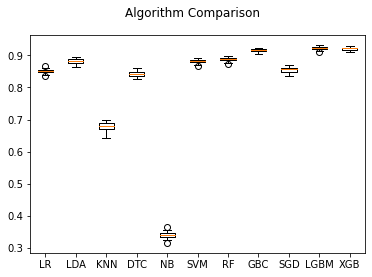

In [10]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from datetime import datetime
import time
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(max_iter=10000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='rbf')))
models.append(("RF", RandomForestClassifier(n_estimators = 100)))
models.append(("GBC", GradientBoostingClassifier(n_estimators=100)))
models.append(("SGD", SGDClassifier(loss="log", penalty="l2")))
models.append(("LGBM", LGBMClassifier(objective='multiclass', random_state=5)))
models.append(("XGB",XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    start_time = time.time()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)
    cv_results = cross_val_score(model, X_train_scaled, y_train_values, cv=cv, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f) %s seconds" % (name, cv_results.mean(), cv_results.std(), time.time() - start_time)
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedKFold,cross_val_score
model = LGBMClassifier(objective='multiclass',random_state=5)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=7)
cv_results = cross_val_score(model, X_train_scaled, y_train_values, cv=cv, scoring="accuracy", n_jobs=-1)
print(cv_results.mean())

In [ ]:
X_train_RNA = X_train.iloc[:,:2500]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_RNA_scaled = scaler.fit_transform(X_train_RNA)
print(X_train_RNA_scaled.shape,y_train_values.shape)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedKFold,cross_val_score
model = LGBMClassifier(objective='multiclass',random_state=5)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=7)
cv_results = cross_val_score(model, X_train_RNA_scaled, y_train_values, cv=cv, scoring="accuracy", n_jobs=-1)
print(cv_results.mean())